In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model 
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input


In [4]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'

In [5]:
# labels, age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    
    # Add a condition to ensure filename has the expected format
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    except (IndexError, ValueError) as e:
        print(f"Skipping file {filename} due to incorrect format: {e}")
        continue

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
#convert to dataframe
# Check if all lists have the same length before creating the DataFrame
if len(image_paths) == len(age_labels) == len(gender_labels):
    df = pd.DataFrame()
    df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
    print(df.head())
else:
    print("The lengths of image_paths, age_labels, and gender_labels do not match.")


                                               image  age  gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1


In [7]:
#map labels for gender

gender_dict = {0: 'Male', 1:' Female'}

## Exploratory Data Analysis

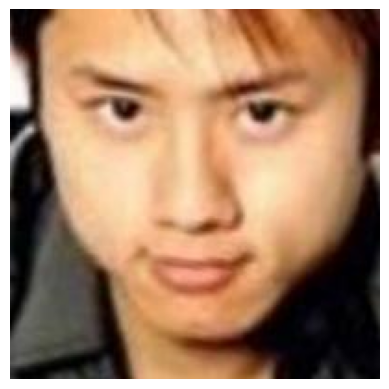

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

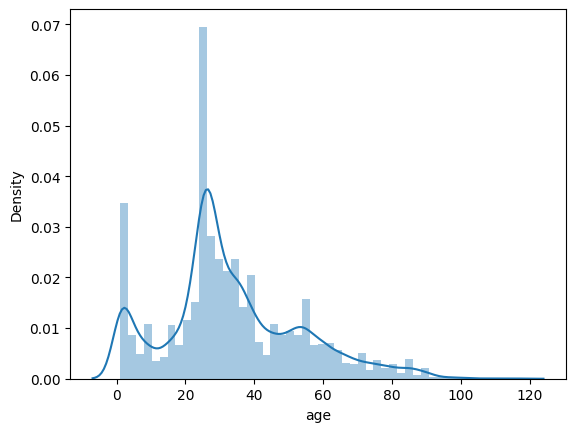

In [9]:
sns.distplot(df['age'])

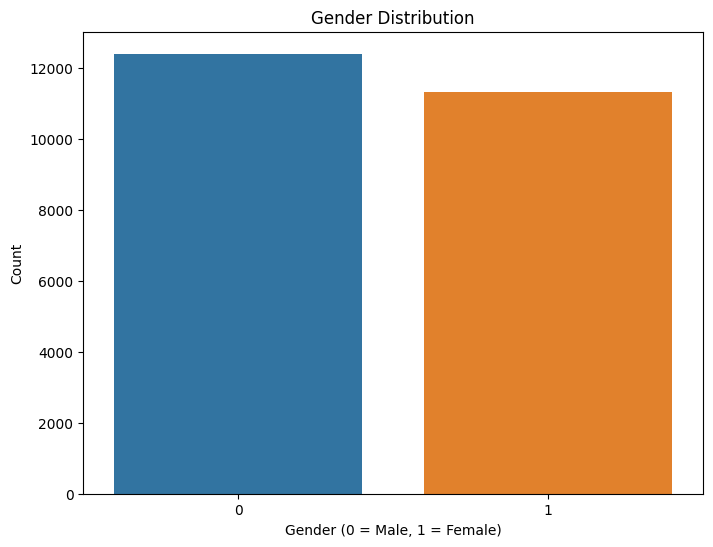

In [10]:
# Set figure size
plt.figure(figsize=(8, 6))

# Create count plot
sns.countplot(x='gender', data=df)

# Add labels
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.title('Gender Distribution')

# Show plot
plt.show()


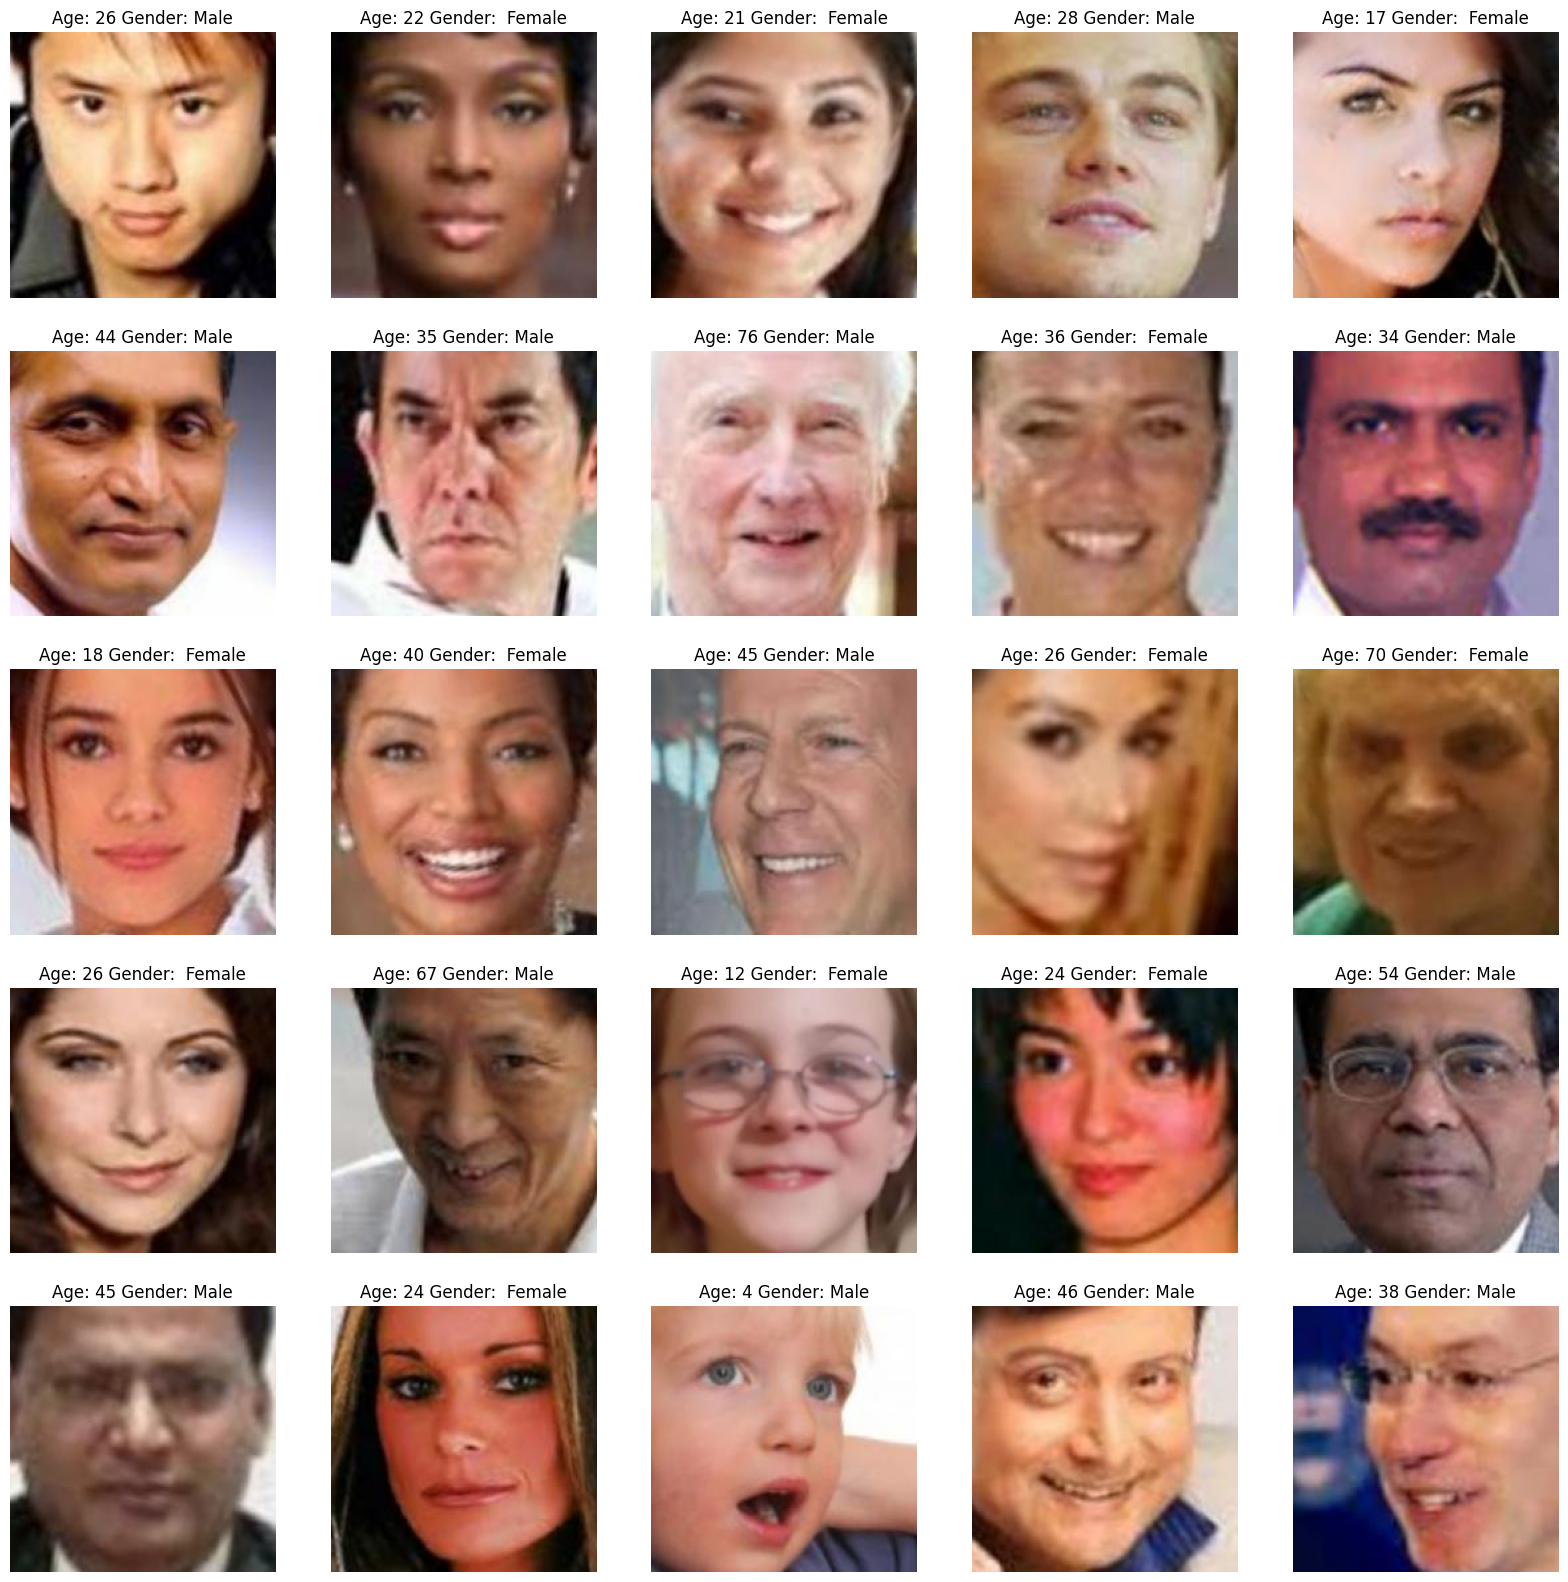

In [11]:
#to display a grid of images
plt.figure(figsize=(20,20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128,128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    #ignore this step if using RGB
    features = features.reshape(len(features), 128,128,1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
#normalize he images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape=(128,128,1)

## Model Creation

In [31]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure your data is properly formatted
y_gender = np.array(y_gender).reshape(-1, 1)
y_age = np.array(y_age).reshape(-1, 1)

# Split data into training and validation sets
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42)

inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# output layers for gender and age prediction
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model with separate metrics for each output
model.compile(
    loss=['binary_crossentropy', 'mae'],  # Binary crossentropy for gender, MAE for age
    optimizer='adam',
    metrics=[['accuracy'], ['mae']]  # Accuracy for gender, MAE for age
)

In [28]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 126, 126,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 63, 63,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 30, 30,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 14,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 6, 256) │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  2,359,552 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

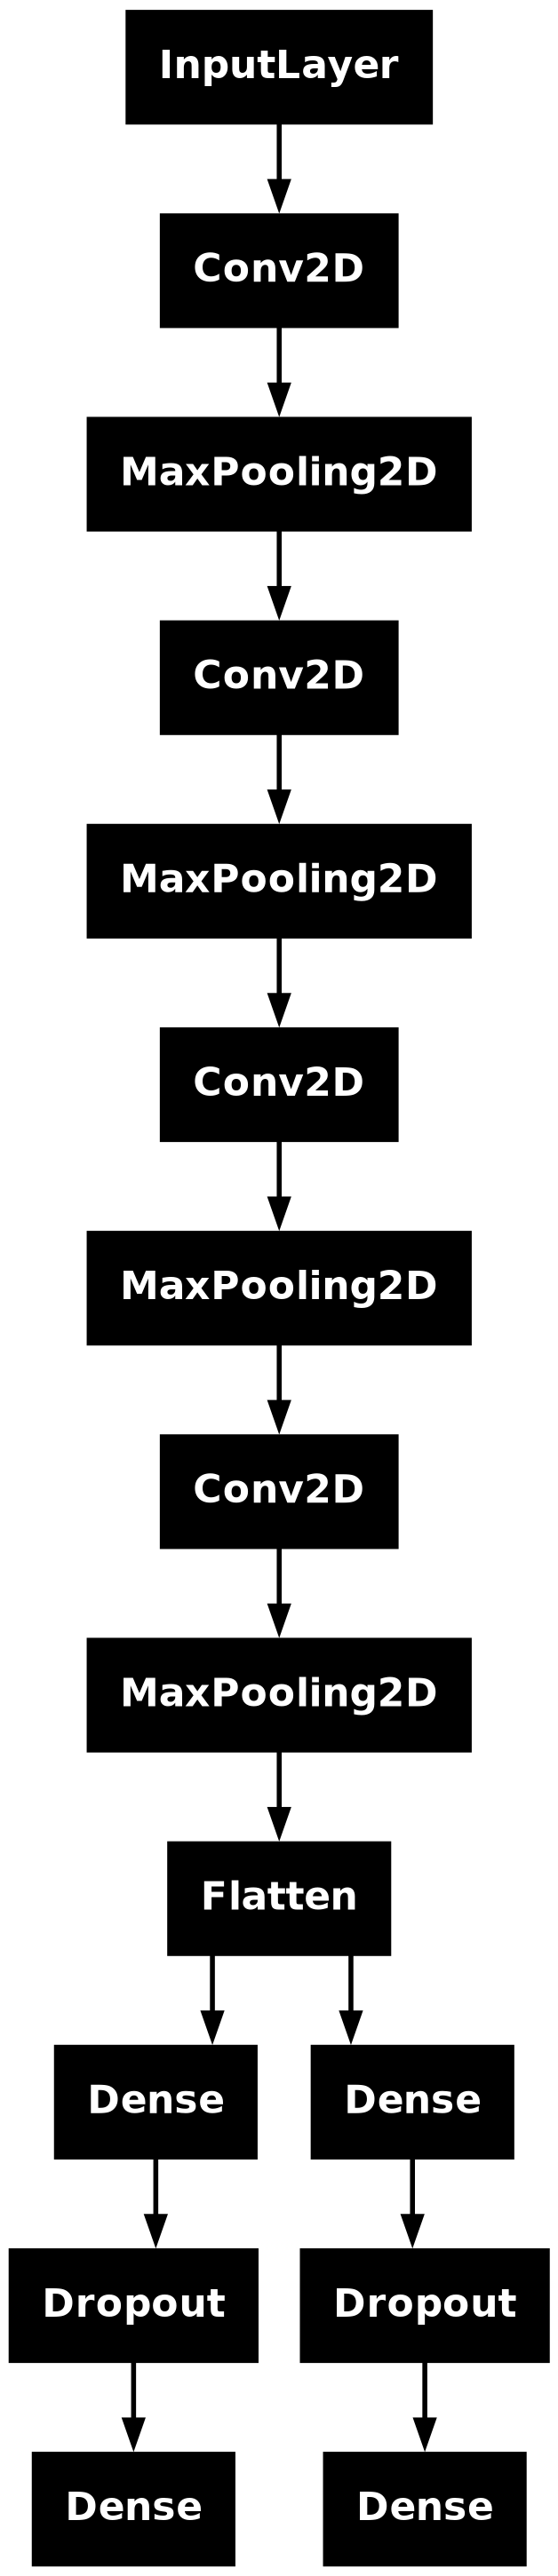

In [29]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# Train the model with validation data
history = model.fit(
    x=X_train,
    y=[y_gender_train, y_age_train],
    batch_size=32,
    epochs=30,
    validation_data=(X_val, [y_gender_val, y_age_val]),
    verbose=1
)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 362s 604ms/step - age_out_mae: 17.6081 - gender_out_accuracy: 0.5192 - loss: 18.3118 - val_age_out_mae: 12.0989 - val_gender_out_accuracy: 0.7330 - val_loss: 12.6414
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 352s 593ms/step - age_out_mae: 11.8232 - gender_out_accuracy: 0.7311 - loss: 12.3585 - val_age_out_mae: 10.1438 - val_gender_out_accuracy: 0.7841 - val_loss: 10.5865
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 383s 594ms/step - age_out_mae: 10.3356 - gender_out_accuracy: 0.7804 - loss: 10.7925 - val_age_out_mae: 9.2349 - val_gender_out_accuracy: 0.8104 - val_loss: 9.6327
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 354s 598ms/step - age_out_mae: 9.2067 - gender_out_accuracy: 0.8046 - loss: 9.6273 - val_age_out_mae: 8.1406 - val_gender_out_accuracy: 0.8307 - val_loss: 8.5007
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 380s 595ms/step - age_out_mae: 8.4146 - gender_out_accuracy: 0.8313 - loss: 8.7861 - val_age_out_mae: 9.1476 - val_gender_out_accuracy: 0.8471